In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold, learning_curve, validation_curve, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
from helpers import *

# Preprocess Data

In [2]:
SEED = 903653851 # my GTID
cur_dir = os.getcwd()

# Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#
df_bm = pd.read_csv(cur_dir + "/data/bank/bank-full" + ".csv", delimiter=';')

#### Bank Marketing

In [3]:
# df_bm.isnull().sum() # checking for nulls, otherwise fill missing values with mean of all values in column

In [4]:
# "age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
one_hot_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
df_one_hot_cols = df_bm[one_hot_cols]
df_one_hot = pd.get_dummies(df_one_hot_cols).astype('category')
df_rest = df_bm.drop(one_hot_cols, axis=1)
df_bm = pd.concat([df_rest, df_one_hot], axis=1)


In [5]:
# Normalization
numerical_cols = ['age','balance','day','duration','campaign','pdays','previous']
df_nums = df_bm[numerical_cols]
df_normalized = (df_nums - df_nums.min()) / (df_nums.max() - df_nums.min())
df_bm_categoricals = df_bm.drop(numerical_cols, axis=1)
df_bm = pd.concat([df_bm_categoricals, df_normalized], axis=1)

# Convert categories to numeric values, put label at the end
new_cols = df_bm.columns.to_list()
new_cols.pop(new_cols.index('y'))
df_bm = df_bm[new_cols + ['y']]
df_bm['y'].replace("yes", 1, inplace=True)
df_bm['y'].replace("no", 0, inplace=True)
df_bm['y'] = df_bm['y'].astype('category')

#### Income Evaluation

In [6]:
''' Needs to be run only once. '''
# Source: https://www.kaggle.com/lodetomasi1995/income-classification
# with open(cur_dir + "/data/income/income_evaluation_clean" + ".csv", 'a') as clean_file:
#     ie_clean = csv.writer(clean_file)
#     with open(cur_dir + "/data/income/income_evaluation" + ".csv", 'r') as ie_file:
#         ie_data = csv.reader(ie_file, delimiter=',')
#         for line in ie_data:
#             row = []
#             for cell in line:
#                 if cell[0] == ' ': cell = cell[1:]
#                 if cell[-1] == ' ': cell = cell[:-1]
#                 row.append(cell)
#             ie_clean.writerow(row)

' Needs to be run only once. '

In [7]:
df_ie = pd.read_csv(cur_dir + "/data/income/income_evaluation_clean" + ".csv", delimiter=',')
print("Data has",len(df_ie),"rows and", len(df_ie.columns),"columns.")
# df_ie.isnull().sum() # checking for nulls, otherwise fill missing values with mean of all values in column

Data has 32561 rows and 15 columns.


In [8]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
one_hot_cols = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
df_one_hot_cols = df_ie[one_hot_cols]
df_one_hot = pd.get_dummies(df_one_hot_cols).astype('category')
df_rest = df_ie.drop(one_hot_cols, axis=1)
df_ie = pd.concat([df_rest, df_one_hot], axis=1)


In [9]:
# Normalization
numerical_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
df_nums = df_ie[numerical_cols]
df_normalized = (df_nums - df_nums.min()) / (df_nums.max() - df_nums.min())
df_ie_categoricals = df_ie.drop(numerical_cols, axis=1)
df_ie = pd.concat([df_ie_categoricals, df_normalized], axis=1)

# Convert categories to numeric values, put label at the end
new_cols = df_ie.columns.to_list()
new_cols.pop(new_cols.index('income'))
df_ie = df_ie[new_cols + ['income']]
df_ie['income'].replace(">50K", 1, inplace=True)
df_ie['income'].replace("<=50K", 0, inplace=True)
df_ie['income'] = df_ie['income'].astype('category')

# Load Data

In [10]:
DATASET1 = "Bank Marketing"
DATASET2 = "Income Evaluation"

# TODO: Choose dataset to run experiments on
dataset = DATASET2
data = df_ie

X, y = getXy(data)
splits = get_splits(data, 0.2)
X_train, X_test, y_train, y_test = splits

train_durations, pred_durations = [], []
best_accuracies, best_f1_scores = [], []

# Decision Tree

In [41]:
# Classifier with default parameters for baseline performance
clf_dt_default = DecisionTreeClassifier(random_state=SEED)
clf_dt_default.fit(X_train, y_train)
y_pred = clf_dt_default.predict(X_test)
clf_dt_default_accuracy = accuracy_score(y_test, y_pred)
clf_dt_default_f1 = f1_score(y_test, y_pred)
print(f"Accuracy of Default Decision Tree is {clf_dt_default_accuracy*100:.2f}%")
print(f"F-1 Score of Default Decision Tree is {clf_dt_default_f1:.2f}")

Accuracy of Default Decision Tree is 80.78%
F-1 Score of Default Decision Tree is 0.61


#### Validation Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

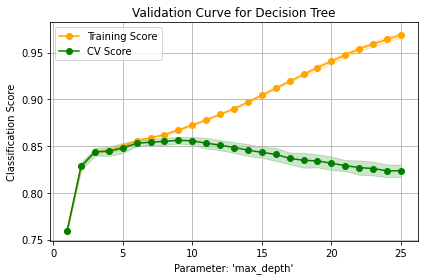

In [12]:
max_depths = range(1,26)
plot_validation_curve(clf_dt_default, X, y, "max_depth", max_depths, cv=5,
    isLogScale=False, clf_long_name="Decision Tree", dataset=dataset)

#### Hyperparameter Tuning

In [13]:
# start_leaf_n = round(0.005 * len(X_train))
# end_leaf_n = round(0.05 * len(X_train))
param_dict = {
        "criterion": ["entropy", "gini"],
        "max_depth": range(1,26) #np.linspace(1, 20, num=25),
        # "min_samples_split": np.linspace(1.0, 0.0, 10, endpoint=False),
        # "min_samples_leaf": np.linspace(start_leaf_n, end_leaf_n, 5).astype('int')
    }
clf_dt_tuned, train_duration, pred_duration, best_accuracy, best_f1 = HT_GridSearchCV(clf_dt_default, splits, param_dict, 5, "DT")
train_durations.append(train_duration)
pred_durations.append(pred_duration)
best_accuracies.append(best_accuracy)
best_f1_scores.append(best_f1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   16.9s finished


Best DT - Training Duration: 17.33
Best DT - Prediction Duration: 0.00
BEST DT SCORE RESULTS:
Accuracy: 85.15%
F1: 0.65
Precision: 0.75
Recall: 0.57
Best Combination of Parameters:  {'criterion': 'gini', 'max_depth': 9}


#### Learning Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

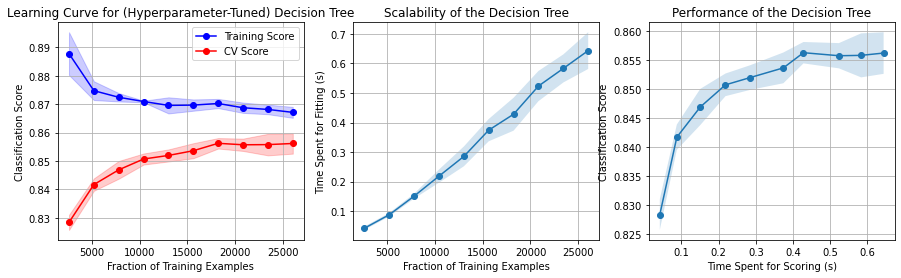

In [14]:
train_sizes = np.linspace(0.1, 1.0, 10)
plot_learning_curve(clf_dt_tuned, X, y, train_sizes, cv=5, clf_long_name="Decision Tree", dataset=dataset)

#### Confusion Matrix

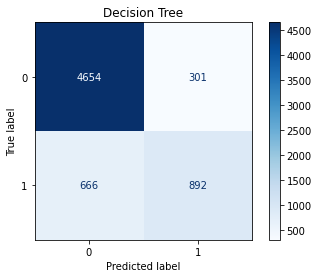

In [15]:
y_pred = clf_dt_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(map(int, clf_dt_tuned.classes_)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Decision Tree")
plt.savefig(dataset + " - " + "DT" + "_Confusion_Matrix")

# Neural Network

In [42]:
# Classifier with default parameters for baseline performance
clf_nn_default = MLPClassifier(random_state=SEED)
clf_nn_default.fit(X_train, y_train)
y_pred = clf_nn_default.predict(X_test)
clf_nn_default_accuracy = accuracy_score(y_test, y_pred)
clf_nn_default_f1 = f1_score(y_test, y_pred)
print(f"Accuracy of Default Neural Network is {clf_nn_default_accuracy*100:.2f}%")
print(f"F-1 Score of Default Neural Network is {clf_nn_default_f1:.2f}")

Accuracy of Default Neural Network is 84.09%
F-1 Score of Default Neural Network is 0.64


/Users/huseyin/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Validation Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

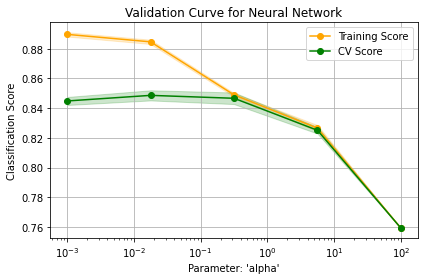

In [17]:
alphas = np.logspace(-3, 2, 5)
plot_validation_curve(clf_nn_default, X, y, "alpha", alphas, cv=5, 
    isLogScale=True, clf_long_name="Neural Network", dataset=dataset)

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

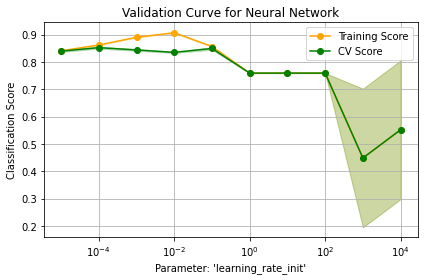

In [18]:
learning_rates = np.logspace(-5, 4, 10)
plot_validation_curve(clf_nn_default, X, y, "learning_rate_init", learning_rates, cv=5,
    isLogScale=True, clf_long_name="Neural Network", dataset=dataset)

#### Hyperparameter Tuning

In [19]:
param_dict = {
        "alpha": alphas,
        "learning_rate_init": learning_rates
    }
clf_nn_tuned, train_duration, pred_duration, best_accuracy, best_f1 = HT_GridSearchCV(clf_nn_default, splits, param_dict, 5, "NN")
train_durations.append(train_duration)
pred_durations.append(pred_duration)
best_accuracies.append(best_accuracy)
best_f1_scores.append(best_f1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.3min finished


Best NN - Training Duration: 884.29
Best NN - Prediction Duration: 0.02
BEST NN SCORE RESULTS:
Accuracy: 84.52%
F1: 0.65
Precision: 0.71
Recall: 0.59
Best Combination of Parameters:  {'alpha': 0.001, 'learning_rate_init': 0.0001}


/Users/huseyin/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Learning Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

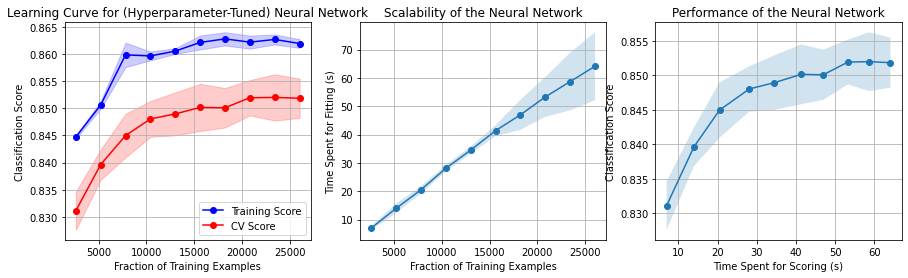

In [20]:
train_sizes = np.linspace(0.1, 1.0, 10)
plot_learning_curve(clf_nn_tuned, X, y, train_sizes, cv=5, clf_long_name="Neural Network", dataset=dataset)

#### Confusion Matrix

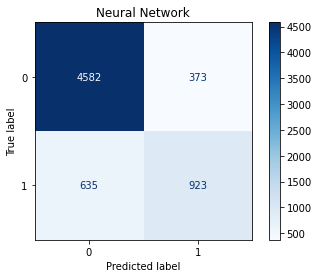

In [21]:
y_pred = clf_nn_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(map(int, clf_nn_tuned.classes_)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Neural Network")
plt.savefig(dataset + " - " + "NN" + "_Confusion_Matrix")

# Boosting

In [43]:
# Classifier with default parameters for baseline performance
# DT = DecisionTreeClassifier(max_depth=1) # documentation suggests this
clf_adaboost = AdaBoostClassifier(base_estimator=clf_dt_default, random_state=SEED)
clf_adaboost.fit(X_train, y_train)   
y_pred = clf_adaboost.predict(X_test)
clf_adaboost_accuracy = accuracy_score(y_test, y_pred)
clf_adaboost_f1 = f1_score(y_test, y_pred)
print(f"Accuracy of AdaBoost is {clf_adaboost_accuracy*100:.2f}%")
print(f"F-1 Score of AdaBoost is {clf_adaboost_f1:.2f}")

Accuracy of AdaBoost is 82.45%
F-1 Score of AdaBoost is 0.62


#### Validation Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

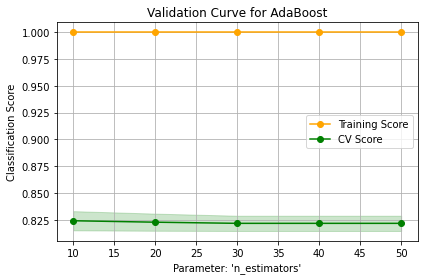

In [23]:
n_estimators = np.linspace(10,50, 5).astype(int)
plot_validation_curve(clf_adaboost, X, y, "n_estimators", n_estimators, cv=5,
    isLogScale=False, clf_long_name="AdaBoost", dataset=dataset)

#### Hyperparameter Tuning

In [24]:
learning_rates = np.logspace(-5, 4, 10)
param_dict = {
        "n_estimators": n_estimators,
        "learning_rate": learning_rates
    }
clf_adaboost_tuned, train_duration, pred_duration, best_accuracy, best_f1 = HT_GridSearchCV(clf_adaboost, splits, param_dict, 5, "AdaB")
train_durations.append(train_duration)
pred_durations.append(pred_duration)
best_accuracies.append(best_accuracy)
best_f1_scores.append(best_f1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.2min finished


Best AdaB - Training Duration: 272.01
Best AdaB - Prediction Duration: 0.12
BEST AdaB SCORE RESULTS:
Accuracy: 82.44%
F1: 0.63
Precision: 0.64
Recall: 0.62
Best Combination of Parameters:  {'learning_rate': 0.1, 'n_estimators': 50}


#### Learning Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

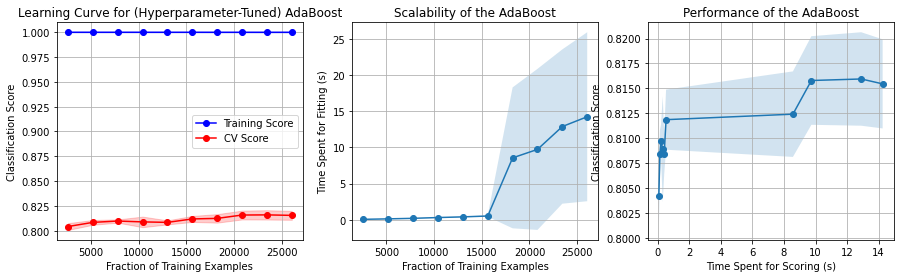

In [25]:
train_sizes = np.linspace(0.1, 1.0, 10)
plot_learning_curve(clf_adaboost_tuned, X, y, train_sizes, cv=5, clf_long_name="AdaBoost", dataset=dataset)

#### Confusion Matrix

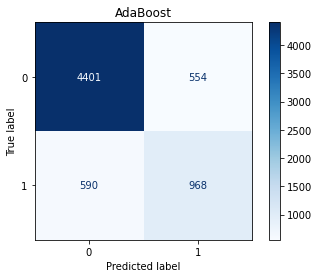

In [26]:
y_pred = clf_adaboost_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(map(int, clf_adaboost_tuned.classes_)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("AdaBoost")
plt.savefig(dataset + " - " + "AdaB" + "_Confusion_Matrix")

# SVM

In [46]:
clf_svc_default = SVC() # kernel='linear'
clf_svc_default.fit(X_train, y_train)
y_pred = clf_svc_default.predict(X_test)
clf_svc_default_accuracy = accuracy_score(y_test, y_pred)
clf_svc_default_f1 = f1_score(y_test, y_pred)
print(f"Accuracy of Default Support Vector Classifier is {clf_svc_default_accuracy*100:.2f}%")
print(f"F-1 Score of Default Support Vector Classifier is {clf_svc_default_f1:.2f}")

Accuracy of Default Support Vector Classifier is 83.62%
F-1 Score of Default Support Vector Classifier is 0.61


#### Validation Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

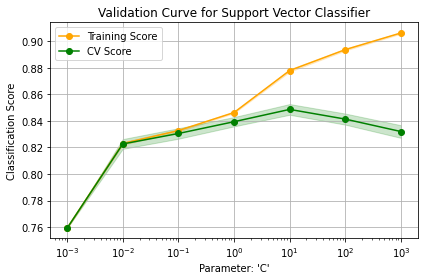

In [47]:
C_values = np.logspace(-3, 3, 7)
plot_validation_curve(clf_svc_default, X, y, "C", C_values, cv=5,
    isLogScale=True, clf_long_name="Support Vector Classifier", dataset=dataset)

#### Hyperparameter Tuning

In [48]:
kernels = ['linear', 'poly', 'rbf']
C_values = np.logspace(-5, 4, 16)
param_dict = {
        "C": C_values,
        "kernel": kernels,
    }
clf_svc_tuned, train_duration, pred_duration, best_accuracy, best_f1 = HT_GridSearchCV(clf_svc_default, splits, param_dict, 5, "SVC")
train_durations.append(train_duration)
pred_durations.append(pred_duration)
best_accuracies.append(best_accuracy)
best_f1_scores.append(best_f1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 188.6min finished


Best SVC - Training Duration: 20473.90
Best SVC - Prediction Duration: 7.38
BEST SVC SCORE RESULTS:
Accuracy: 84.48%
F1: 0.64
Precision: 0.72
Recall: 0.57
Best Combination of Parameters:  {'C': 10000.0, 'kernel': 'linear'}


#### Learning Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

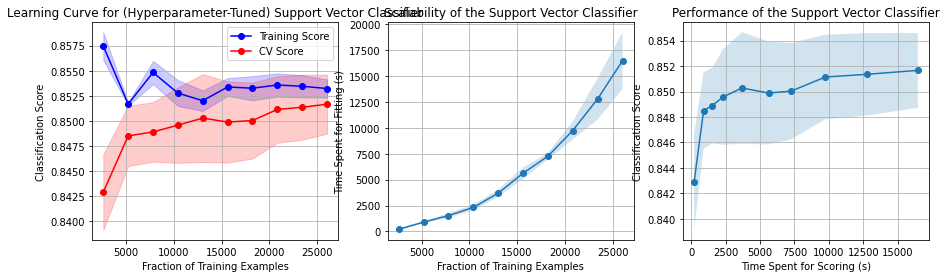

In [49]:
train_sizes = np.linspace(0.1, 1.0, 10)
plot_learning_curve(clf_svc_tuned, X, y, train_sizes, cv=5, clf_long_name="Support Vector Classifier", dataset=dataset)

#### Confusion Matrix

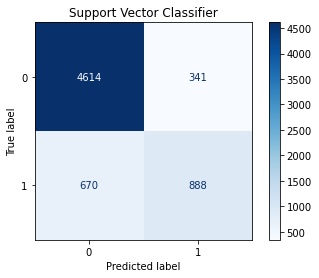

In [51]:
y_pred = clf_svc_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(map(int, clf_svc_tuned.classes_)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Support Vector Classifier")
plt.savefig(dataset + " - " + "SVC" + "_Confusion_Matrix")

# kNN

In [45]:
clf_knn_default = KNeighborsClassifier()
clf_knn_default.fit(X_train, y_train)
y_pred = clf_knn_default.predict(X_test)
clf_knn_default_accuracy = accuracy_score(y_test, y_pred)
clf_knn_default_f1 = f1_score(y_test, y_pred)
print(f"Accuracy of Default k-Nearest Neighbor is {clf_knn_default_accuracy*100:.2f}%")
print(f"F-1 Score of Default k-Nearest Neighbor is {clf_knn_default_f1:.2f}")

Accuracy of Default k-Nearest Neighbor is 82.11%
F-1 Score of Default k-Nearest Neighbor is 0.60


#### Validation Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

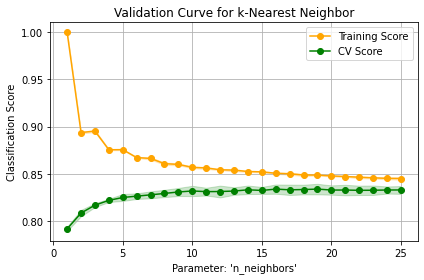

In [36]:
neighbors = range(1,26)
plot_validation_curve(clf_knn_default, X, y, "n_neighbors", neighbors, cv=5,
    isLogScale=False, clf_long_name="k-Nearest Neighbor", dataset=dataset)

#### Hyperparameter Tuning

In [37]:
weights = ["uniform", "distance"]
param_dict = {
        "n_neighbors": neighbors,
        "weights": weights
    }
clf_knn_tuned, train_duration, pred_duration, best_accuracy, best_f1 = HT_GridSearchCV(clf_knn_default, splits, param_dict, 5, "kNN")
train_durations.append(train_duration)
pred_durations.append(pred_duration)
best_accuracies.append(best_accuracy)
best_f1_scores.append(best_f1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 21.0min finished


Best kNN - Training Duration: 1262.88
Best kNN - Prediction Duration: 24.63
BEST kNN SCORE RESULTS:
Accuracy: 83.03%
F1: 0.61
Precision: 0.67
Recall: 0.57
Best Combination of Parameters:  {'n_neighbors': 25, 'weights': 'uniform'}


#### Learning Curve

<module 'matplotlib.pyplot' from '/Users/huseyin/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

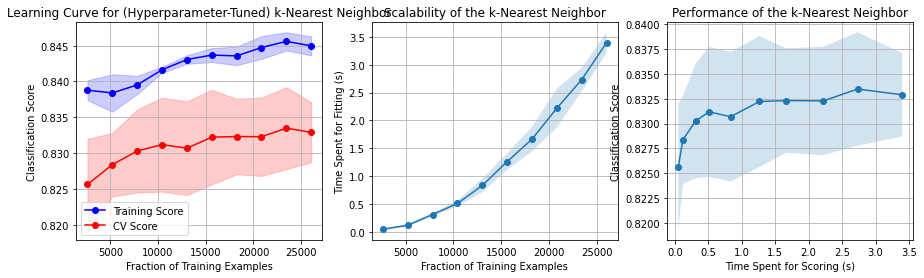

In [38]:
train_sizes = np.linspace(0.1, 1.0, 10)
plot_learning_curve(clf_knn_tuned, X, y, train_sizes, cv=5, clf_long_name="k-Nearest Neighbor", dataset=dataset)

#### Confusion Matrix

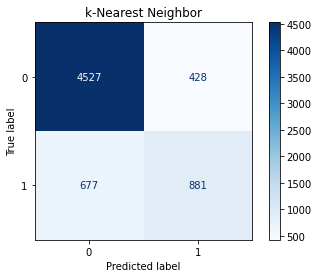

In [39]:
y_pred = clf_knn_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(map(int, clf_knn_tuned.classes_)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("k-Nearest Neighbor")
plt.savefig(dataset + " - " + "kNN" + "_Confusion_Matrix")

# Model Comparison

#### Comparing Accuracies

In [55]:
# train_durations2 = [15.58, 828.31, 25.57, 31599.67, 733.97]
# pred_durations2 = [0.00, 0.02, 0.00, 3.91, 15.95]
# best_accuracies2 = [90.28, 90.55, 87.54, 90.25, 89.51]
# best_f1_scores2 = [0.41, 0.51, 0.47, 0.46, 0.31]
models = ["DT", "NN", "AdaB", "SVM", "kNN"]

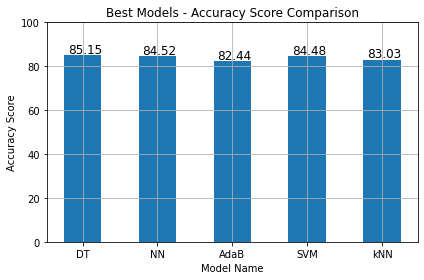

In [67]:
best_accuracies_rounded = [round(el*100, 2) for el in best_accuracies]
fix, ax = plt.subplots()
plt.title(f"Best Models - Accuracy Score Comparison")
ax.bar(models, best_accuracies_rounded, width=0.5)
for i,v in enumerate(best_accuracies_rounded):
    plt.text(i-.2, v+1, v, color="black", fontsize=12)
plt.xlabel("Model Name")
plt.ylabel("Accuracy Score")
plt.ylim(0, 100)
plt.tight_layout()
plt.grid()
plt.savefig(f"{dataset} - Best_Models_Accuracy_Score_Comparison")

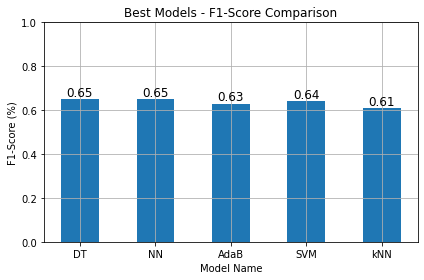

In [84]:
best_f1_scores_rounded = [round(v, 2) for v in best_f1_scores]
fix, ax = plt.subplots()
plt.title(f"Best Models - F1-Score Comparison")
ax.bar(models, best_f1_scores_rounded, width=0.5)
for i,v in enumerate(best_f1_scores_rounded):
    plt.text(i, v, v, color="black", fontsize=12, va="bottom", ha="center")
plt.xlabel("Model Name")
plt.ylabel("F1-Score (%)")
plt.ylim(0, 1)
plt.tight_layout()
plt.grid()
plt.savefig(f"{dataset} - Best_Models_F1-Score_Comparison")

#### Comparing Runtime

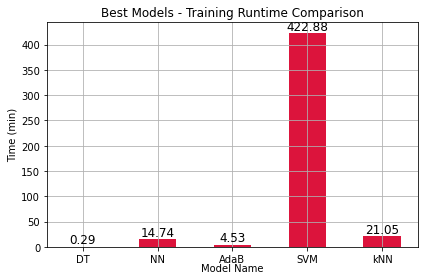

In [88]:
train_durations_min = [v/60 for v in train_durations]
fix, ax = plt.subplots()
plt.title(f"Best Models - Training Runtime Comparison")
ax.bar(models, train_durations_min, width=0.5, color='crimson')
for i,v in enumerate(train_durations_min):
    plt.text(i, v, f"{v:.2f}", color="black", fontsize=12, ha="center", va="bottom")
plt.xlabel("Model Name", va="center")
plt.ylabel("Time (min)")
plt.tight_layout()
plt.grid()
plt.savefig(f"{dataset} - Best_Models_Training_Runtime_Comparison")

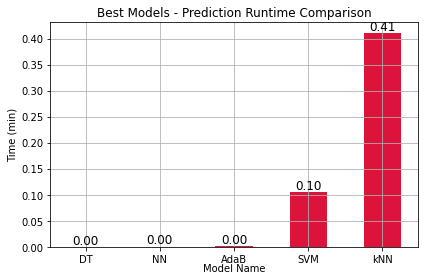

In [89]:
pred_durations_min = [v/60 for v in pred_durations]
fix, ax = plt.subplots()
plt.title(f"Best Models - Prediction Runtime Comparison")
ax.bar(models, pred_durations_min, width=0.5, color='crimson')
for i,v in enumerate(pred_durations_min):
    plt.text(i, v, f"{v:.2f}", color="black", fontsize=12, ha="center", va="bottom")
plt.xlabel("Model Name", va="center")
plt.ylabel("Time (min)")
plt.tight_layout()
plt.grid()
plt.savefig(f"{dataset} - Best_Models_Prediction_Runtime_Comparison")

#### Comparing Runtime